In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import multiprocessing
from scipy.spatial.distance import cdist
import yaml

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
EXP_NAME = str(Path().resolve()).split('/')[-1]

In [4]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [5]:
def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        epoch_df['speedMps'] = target_df.loc[idx, 'speedMps']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [6]:
import plotly.express as px

def visualize_trafic(df):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            text='phoneName',
                            
                            #Here, plotly detects color of series
                            color="collectionName",
                            labels="collectionName",
                            
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()


def visualize_collection(df, root_dir, collection_name='2021-04-29-US-SJC-2'):
    gt_df = pd.read_csv(root_dir / 'all_ground_truth.csv')
    gt_df['phoneName'] = 'ground truth'
    gt_df = pd.concat([df, gt_df])
    target_df = gt_df[gt_df['collectionName']==collection_name]   
    target_df['elapsed_epoch'] = ((target_df['millisSinceGpsEpoch'] - target_df['millisSinceGpsEpoch'].min()) / 1000).astype(str).to_numpy()
    fig = px.scatter_mapbox(target_df,
                                
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            text='elapsed_epoch',
                                
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                                
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="{collection_name}")
    fig.show()

In [7]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    if "phone" not in input_df.columns:
        input_df["phone"] = input_df["collectionName"] + "_" + input_df["phoneName"]

    if "target_latDeg" not in input_df.columns:
        processes = multiprocessing.cpu_count()
        with multiprocessing.Pool(processes=processes) as pool:
            gr = input_df.groupby(['collectionName','phoneName'])
            dfs = pool.imap_unordered(get_ground_truth, gr)
            dfs = tqdm(dfs, total=len(gr))
            dfs = list(dfs)
        input_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).reset_index(drop=True)     


    output_df = input_df.copy()
    
    output_df['error'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.target_latDeg, r.target_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['error'].mean()
    print(f'mean error: {meter_score}')

    scores = []
    p_50_scores = []
    p_95_scores = []
    mean_scores = []
    phones = []
    score_df = pd.DataFrame()
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'error'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'error'], 95)
        # print(f"{phone} | 50:{p_50:.5g}| 95:{p_95:.5g}")
        p_50_scores.append(p_50)
        p_95_scores.append(p_95)
        mean_scores.append(np.mean([p_50, p_95]))
        phones.append(phone)

        scores.append(p_50)
        scores.append(p_95)

    score_df["phone"] = phones
    score_df["p_50_score"] = p_50_scores
    score_df["p_95_score"] = p_95_scores
    score_df["mean_score"] = mean_scores
    
    comp_score = sum(scores) / len(scores)
    print(f"competition metric:{comp_score}")
    return output_df, score_df

In [8]:
import simdkalman

# define kf model
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

In [9]:
def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in tqdm(unique_paths):
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [10]:
def linear_interpolation(input_df, speed_thr=45):
    dfs = pd.DataFrame()
    for (collectionName, phoneName), df in input_df.groupby(['collectionName','phoneName']):

        df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
        df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
        df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
        df['speed'].fillna(0, inplace=True)

        # 一度欠損値にする
        df.loc[speed_thr<df['speed'], ['latDeg', 'lngDeg']] = np.nan
        df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
        df = df.set_index('dummy_datetime')

        # 時間に合わせて線形補間
        df = df.interpolate(method='time').reset_index(drop=True)
        dfs = pd.concat([dfs, df]).reset_index(drop=True)
    return dfs

In [11]:
# data womizumasi
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
 
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')

    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])

    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)


    # Leave only records to be interpolated(missing coords data)
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]

    return lerp_df[org_columns]


def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df


def apply_mean(df):
    lerp = make_lerp_data(df)
    mean_df = calc_mean_pred(df, lerp)
    return mean_df

In [12]:
def get_removedevice(input_df: pd.DataFrame, device: str) -> pd.DataFrame:
    input_df['index'] = input_df.index
    input_df = input_df.sort_values('millisSinceGpsEpoch')
    input_df.index = input_df['millisSinceGpsEpoch'].values

    output_df = pd.DataFrame() 
    for _, subdf in input_df.groupby('collectionName'):

        phones = subdf['phoneName'].unique()

        if (len(phones) == 1) or (not device in phones):
            output_df = pd.concat([output_df, subdf])
            continue

        origin_df = subdf.copy()
        
        _index = subdf['phoneName']==device
        subdf.loc[_index, 'latDeg'] = np.nan
        subdf.loc[_index, 'lngDeg'] = np.nan
        subdf = subdf.interpolate(method='index', limit_area='inside')

        _index = subdf['latDeg'].isnull()
        subdf.loc[_index, 'latDeg'] = origin_df.loc[_index, 'latDeg'].values
        subdf.loc[_index, 'lngDeg'] = origin_df.loc[_index, 'lngDeg'].values

        output_df = pd.concat([output_df, subdf])

    output_df.index = output_df['index'].values
    output_df = output_df.sort_index()

    del output_df['index']
    
    return output_df

In [14]:
road_points = pd.read_csv('../../input/all_ground_truth.csv')
road_points["place"] = road_points["collectionName"].str[11:]
road_points = road_points[["lngDeg", "latDeg", "place"]]

In [23]:
def snap_to_grid(sub, min_thr, max_thr):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_latDeg_'] = sub['latDeg']
    sub['_lngDeg_'] = sub['lngDeg']
    sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), '_latDeg_'] = sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), 'matched_latDeg']
    sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), '_lngDeg_'] = sub.loc[(min_thr < sub['dist'])&(sub['dist'] < max_thr), 'matched_lngDeg']
    return sub.copy()

from scipy.spatial.distance import cdist

def add_xy(df):
    df['point'] = [(x, y) for x,y in zip(df['lngDeg'], df['latDeg'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]


def matching_point(target_df, target_road_points=road_points):
    # place = target_df["place"].unique()[0]
    # target_road_points = road_points[road_points["place"]==place]
    target_df['matched_point'] = [closest_point(x, list(target_road_points['point'])) for x in tqdm(target_df['point'])]
    target_df['lngDeg'] = target_df['matched_point'].apply(lambda x: x[0])
    target_df['latDeg'] = target_df['matched_point'].apply(lambda x: x[1])
    return target_df


def apply_snap_to_grid(df, road_points, phase="train"):

    df["place"] = df["collectionName"].str[11:]

    df = add_xy(df)
    road_points = add_xy(road_points)
    df_list = []
    ncpu = multiprocessing.cpu_count()
    for place, target_df in tqdm(df.groupby("place")):

        if ((phase=="train")&(place in ['US-SJC-1', 'US-SJC-2'])) | ((phase=="test")&(place in ['US-SJC-2', 'US-SJC-3'])):
            target_df = target_df.reset_index(drop=True)
            k = round(len(target_df)/ncpu)
            target_dfs = [target_df.loc[i:i+k-1, :] for i in range(0, len(target_df), k)]
            with multiprocessing.Pool(processes=ncpu) as pool:
                dfs = pool.imap_unordered(matching_point, target_dfs)
                dfs = list(tqdm(dfs, total=len(target_dfs)))
                df = pd.concat(dfs)
            df_list.append(df)
        else:
            df_list.append(target_df)

    df = pd.concat(df_list).reset_index(drop=True)
    return df

In [16]:
# waypointを補正したdataset
root_dir = Path('../../input/google-smartphone-decimeter-challenge')

In [17]:
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
# train_df, score_df = check_score(train_df)
# score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

In [18]:
train_df = linear_interpolation(train_df)
# rain_df, score_df = check_score(train_df)
# score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

In [19]:
train_df = apply_kf_smoothing(train_df)
# train_df, score_df = check_score(train_df)
# score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [20]:
train_df = apply_mean(train_df)
# train_df, score_df = check_score(train_df)
# score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

In [21]:
train_df = get_removedevice(train_df, 'SamsungS20Ultra')
# train_df, score_df = check_score(train_df)
# score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

In [24]:
train_df = apply_snap_to_grid(train_df, road_points)
train_df, score_df = check_score(train_df)
score_df.sort_values("mean_score", ascending=False).head(10).style.bar(subset=['p_50_score', 'p_95_score', 'mean_score'], color=['teal'])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

mean error: 2.6457261898900777
competition metric:3.699341128435263


,phone,p_50_score,p_95_score,mean_score
59,2021-04-22-US-SJC-1_Pixel4,5.282210,20.963602,13.122906
60,2021-04-22-US-SJC-1_SamsungS20Ultra,4.902445,20.727946,12.815195
71,2021-04-29-US-SJC-2_Pixel4,4.118246,21.489939,12.804093
72,2021-04-29-US-SJC-2_SamsungS20Ultra,3.286376,21.824012,12.555194
66,2021-04-28-US-SJC-1_Pixel4,3.911748,18.008976,10.960362
67,2021-04-28-US-SJC-1_SamsungS20Ultra,3.217483,17.588809,10.403146
68,2021-04-29-US-MTV-1_Pixel4,5.027345,10.966539,7.996942
69,2021-04-29-US-MTV-1_Pixel5,4.586693,10.707323,7.647008
70,2021-04-29-US-MTV-1_SamsungS20Ultra,4.189269,9.211020,6.700145
49,2021-01-05-US-SVL-1_Pixel5,3.333992,9.062322,6.198157


## test

In [25]:
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv')

In [26]:
test_df = linear_interpolation(test_df)
test_df = apply_kf_smoothing(test_df)
test_df = apply_mean(test_df)
test_df = get_removedevice(test_df, 'SamsungS20Ultra')
test_df = apply_snap_to_grid(test_df, road_points, phase="test")

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## create features

In [27]:
def create_features(input_df, phase="train"):
    output_df = pd.DataFrame()
    for (collection_name, phone_name), df in input_df.groupby(["collectionName", "phoneName"]):
        df = df.sort_values("millisSinceGpsEpoch").reset_index(drop=True)
        if phase == "train":
            df = df[["collectionName", "phoneName", "millisSinceGpsEpoch", "latDeg", "lngDeg", "speedMps"]]
        else:
            df = df[["collectionName", "phoneName", "millisSinceGpsEpoch", "latDeg", "lngDeg"]]

        for i in [1, 3, 5, 7, 10, 15, 20]:
            df[f"pre{i}_dist"] = calc_haversine(df["latDeg"], df["lngDeg"], df["latDeg"].shift(i), df["lngDeg"].shift(i)).abs()
            df[f"post{i}_dist"] = calc_haversine(df["latDeg"], df["lngDeg"], df["latDeg"].shift(i*-1), df["lngDeg"].shift(i*-1)).abs()
            df[f"pre{i}_delta_t"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].shift(i)).abs() / 1000
            df[f"post{i}_delta_t"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].shift(i*-1)).abs() / 1000
            df[f"pre{i}_speedMps"] = df[f"pre{i}_dist"] / df[f"pre{i}_delta_t"]
            df[f"post{i}_speedMps"] = df[f"post{i}_dist"] / df[f"post{i}_delta_t"]
            df[f"mean{i}_speedMps"] = (df[f"pre{i}_speedMps"] + df[f"post{i}_speedMps"]) / 2
        
        df["elapsed_time"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].min()) / 1000
        df["arrived_time"] = (df["millisSinceGpsEpoch"].max() - df["millisSinceGpsEpoch"]) / 1000
        output_df = pd.concat([output_df, df]).reset_index(drop=True)
 
    return output_df

In [28]:
train_feat_df = create_features(train_df, phase="train")
test_feat_df = create_features(test_df, phase="test")
train_feat_df.shape, test_feat_df.shape

((131342, 57), (91486, 56))

## preprocessing

In [29]:
from sklearn.preprocessing import LabelEncoder

whole_df = pd.concat([train_feat_df, test_feat_df]).reset_index(drop=True)

le_co = LabelEncoder()
le_co.fit(whole_df['collectionName'])
le_ph = LabelEncoder()
le_ph.fit(whole_df['phoneName'])


def preprocess(input_df, le1=le_co, le2=le_ph):
    output_df = input_df.copy()
    # LE
    output_df['collectionName'] = le1.transform(input_df['collectionName'])
    output_df['phoneName'] = le2.transform(input_df['phoneName'])
    return output_df

train = preprocess(train_feat_df)
test = preprocess(test_feat_df)

In [30]:

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 
    'metric':'rmse',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .05,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 100000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [37]:

import lightgbm as lgbm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from wandb.lightgbm import wandb_callback
from sklearn.model_selection import StratifiedKFold
import wandb


def fit_lgbm(X, 
             y, 
             test,
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    oofs = []  # 全てのoofをdfで格納する
    preds = []  # 全ての予測値をdfで格納する
    val_scores = []

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(X, X['collectionName'])]
    for fold in range(5):
        # 指定したfoldのみループを回す
        if fold not in USE_FOLDS:
            continue

        print('=' * 20)
        print(f'Fold {fold}')
        print('=' * 20)


        # training data の target と同じだけのゼロ配列を用意
        oof_pred = np.zeros(y.shape[0], dtype=np.float)

        # train/valid data
        trn_idx_for_train, val_idx_for_train = train_fold[fold]
        x_train = X.loc[trn_idx_for_train, :].reset_index(drop=True)
        x_valid = X.loc[val_idx_for_train, :].reset_index(drop=True)
        y_train = y.loc[trn_idx_for_train].reset_index(drop=True)
        y_valid = y.loc[val_idx_for_train].reset_index(drop=True)
        
        # clf = MultiOutputRegressor(lgbm.LGBMRegressor(**params))
        clf = lgbm.LGBMRegressor(**params)

        # loggers
        RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
        wandb.init(project='outdoor', entity='kuto5046', group=RUN_NAME)
        wandb.run.name = RUN_NAME + f'-fold-{fold}'
        wandb_config = wandb.config
        wandb_config['model_name'] = "lightGBM"
        wandb_config['comment'] = NOTES
        # wandb.watch(clf)
        
     
        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose,
                callbacks=[wandb_callback()])

        pred_i = clf.predict(x_valid)
        x_valid["pred"] = pred_i
        x_valid["speedMps"] = y_valid.to_numpy() 
        oofs.append(x_valid)
        
        score = mean_squared_error(y_valid, pred_i) ** .5
        val_scores.append(score)
        print(f'Fold {fold} RMSE: {score:.4f}')

        wandb.finish()
        
        pred = clf.predict(test)
        preds.append(pred)
    oof_df = pd.concat(oofs).reset_index(drop=True) 
    all_score = mean_squared_error(oof_df["speedMps"], oof_df["oof"]) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSE: {:.4f}'.format(all_score))
    features = x_train.columns.values
    return oof_df, preds

In [40]:
# drop_col = ["millisSinceGpsEpoch"]
target_col = ["speedMps"]
y = train[target_col]
X = train.drop(target_col, axis=1)

In [42]:
oof_df, preds = fit_lgbm(X, y, test, params=params, verbose=2000)

Fold 0


valid_0_rmse,0.06136
_runtime,24
_timestamp,1623414757
_step,4109


valid_0_rmse,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training until validation scores don't improve for 100 rounds
[2000]	valid_0's rmse: 0.362326
[4000]	valid_0's rmse: 0.329717
[6000]	valid_0's rmse: 0.313401
[8000]	valid_0's rmse: 0.303101
[10000]	valid_0's rmse: 0.296037
[12000]	valid_0's rmse: 0.290781
[14000]	valid_0's rmse: 0.286901
[16000]	valid_0's rmse: 0.283845
[18000]	valid_0's rmse: 0.281475
[20000]	valid_0's rmse: 0.279244
Early stopping, best iteration is:
[19989]	valid_0's rmse: 0.279219
Fold 0 RMSE: 0.2792


valid_0_rmse,0.27925
_runtime,112
_timestamp,1623414879
_step,20088


valid_0_rmse,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 1


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[2000]	valid_0's rmse: 0.365841
[4000]	valid_0's rmse: 0.332874
[6000]	valid_0's rmse: 0.315926
[8000]	valid_0's rmse: 0.305271
[10000]	valid_0's rmse: 0.29787
[12000]	valid_0's rmse: 0.292697
[14000]	valid_0's rmse: 0.28856
[16000]	valid_0's rmse: 0.285497
[18000]	valid_0's rmse: 0.282971
[20000]	valid_0's rmse: 0.281011
[22000]	valid_0's rmse: 0.279276
[24000]	valid_0's rmse: 0.27791
[26000]	valid_0's rmse: 0.276742
[28000]	valid_0's rmse: 0.275645
[30000]	valid_0's rmse: 0.274758
[32000]	valid_0's rmse: 0.274017
Early stopping, best iteration is:
[31950]	valid_0's rmse: 0.273999
Fold 1 RMSE: 0.2740


valid_0_rmse,0.274
_runtime,194
_timestamp,1623415097
_step,32049


valid_0_rmse,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 2


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[2000]	valid_0's rmse: 0.364176
[4000]	valid_0's rmse: 0.331912
[6000]	valid_0's rmse: 0.31546
[8000]	valid_0's rmse: 0.305221
[10000]	valid_0's rmse: 0.298144
[12000]	valid_0's rmse: 0.292938
[14000]	valid_0's rmse: 0.288956
[16000]	valid_0's rmse: 0.285835
[18000]	valid_0's rmse: 0.283475
[20000]	valid_0's rmse: 0.281501
[22000]	valid_0's rmse: 0.279903
[24000]	valid_0's rmse: 0.2785
[26000]	valid_0's rmse: 0.277225
[28000]	valid_0's rmse: 0.276165
[30000]	valid_0's rmse: 0.275227
Early stopping, best iteration is:
[31116]	valid_0's rmse: 0.27477
Fold 2 RMSE: 0.2748


valid_0_rmse,0.27478
_runtime,174
_timestamp,1623415309
_step,31215


valid_0_rmse,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 3


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[2000]	valid_0's rmse: 0.363179
[4000]	valid_0's rmse: 0.33065
[6000]	valid_0's rmse: 0.314094
[8000]	valid_0's rmse: 0.30387
[10000]	valid_0's rmse: 0.296251
[12000]	valid_0's rmse: 0.290808
[14000]	valid_0's rmse: 0.286845
[16000]	valid_0's rmse: 0.283666
[18000]	valid_0's rmse: 0.281071
[20000]	valid_0's rmse: 0.279072
[22000]	valid_0's rmse: 0.277265
[24000]	valid_0's rmse: 0.27579
[26000]	valid_0's rmse: 0.274591
Early stopping, best iteration is:
[27186]	valid_0's rmse: 0.273874
Fold 3 RMSE: 0.2739


valid_0_rmse,0.27389
_runtime,202
_timestamp,1623415551
_step,27285


valid_0_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 4


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[2000]	valid_0's rmse: 0.348958
[4000]	valid_0's rmse: 0.316182
[6000]	valid_0's rmse: 0.298868
[8000]	valid_0's rmse: 0.288039
[10000]	valid_0's rmse: 0.280543
[12000]	valid_0's rmse: 0.274893
[14000]	valid_0's rmse: 0.270632
[16000]	valid_0's rmse: 0.267235
[18000]	valid_0's rmse: 0.264558
[20000]	valid_0's rmse: 0.262263
[22000]	valid_0's rmse: 0.260383
[24000]	valid_0's rmse: 0.25888
[26000]	valid_0's rmse: 0.257573
[28000]	valid_0's rmse: 0.256426
[30000]	valid_0's rmse: 0.25551
[32000]	valid_0's rmse: 0.254679
[34000]	valid_0's rmse: 0.253944
[36000]	valid_0's rmse: 0.253291
[38000]	valid_0's rmse: 0.252707
[40000]	valid_0's rmse: 0.252221
[42000]	valid_0's rmse: 0.251736
[44000]	valid_0's rmse: 0.251317
Early stopping, best iteration is:
[44604]	valid_0's rmse: 0.251174
Fold 4 RMSE: 0.2512


valid_0_rmse,0.25118
_runtime,249
_timestamp,1623415833
_step,44703


valid_0_rmse,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


--------------------------------------------------
FINISHED | Whole RMSE: 0.2708


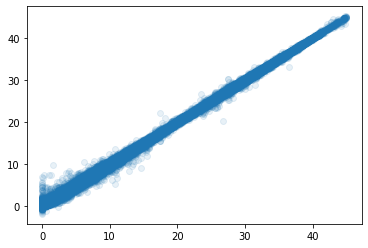

In [43]:
# Whole RMSE: 0.2708
plt.scatter(oof_df["speedMps"], oof_df["oof"], alpha=0.1)

In [57]:
test["pred"] = np.mean(preds, axis=0)
oof_df["collectionName"] = le_co.inverse_transform(oof_df["collectionName"])
test["collectionName"] = le_co.inverse_transform(test["collectionName"])

oof_df["phoneName"] = le_ph.inverse_transform(oof_df["phoneName"])
test["phoneName"] = le_ph.inverse_transform(test["phoneName"])

In [62]:
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
train_df = train_df.merge(oof_df[["collectionName", "phoneName", "millisSinceGpsEpoch", "pred"]], on=["collectionName", "phoneName", "millisSinceGpsEpoch"])
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,pred
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0.101259
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0.025110
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,-0.016409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0.015611
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0.009828
...,...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0.025891
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0.016220
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0.064718
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,-0.012927


In [63]:
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
test_df = test_df.merge(test[["collectionName", "phoneName", "millisSinceGpsEpoch", "pred"]], on=["collectionName", "phoneName", "millisSinceGpsEpoch"])
test_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,pred
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Pixel4,0.114614
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416646,-122.082040,-31.76,2020-05-15-US-MTV-1_Pixel4,-0.006341
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416652,-122.082039,-31.65,2020-05-15-US-MTV-1_Pixel4,0.001867
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416607,-122.082063,-31.52,2020-05-15-US-MTV-1_Pixel4,-0.016958
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416609,-122.082073,-28.95,2020-05-15-US-MTV-1_Pixel4,0.051821
...,...,...,...,...,...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000,37.334539,-121.899383,-8.39,2021-04-29-US-SJC-3_SamsungS20Ultra,-0.054566
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000,37.334545,-121.899380,-7.36,2021-04-29-US-SJC-3_SamsungS20Ultra,-0.101317
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000,37.334551,-121.899371,-4.08,2021-04-29-US-SJC-3_SamsungS20Ultra,-0.065977
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000,37.334540,-121.899371,-5.70,2021-04-29-US-SJC-3_SamsungS20Ultra,-0.066400


In [64]:
train_df.to_csv(root_dir / "baseline_locations_train_with_speed.csv", index=False)
test_df.to_csv(root_dir / "baseline_locations_test_with_speed.csv", index=False)